In [2]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import ward, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering

In [3]:
# Load in the data
data = pd.read_csv('medium_titles.csv', index_col=0, header = None, names = ['Text'])
data.shape

(192, 1)

In [4]:
data.head()

,Text
0,Design better data tables
1,Your Facebook data is creepy as hell
2,"Cheat Sheets for AI, Neural Networks, Machine ..."
3,Why so many data scientists are leaving their ...
4,"Why SQL is beating NoSQL, and what this means ..."


In [5]:
# Tokenizer to return stemmed words, we use this
def tokenize_and_stem(text_file):
    # declaring stemmer and stopwords language
    stemmer = SnowballStemmer("english")
    stop_words = set(STOPWORDS)
    words = word_tokenize(text_file)
    filtered = [w for w in words if w not in stop_words]
    stems = [stemmer.stem(t) for t in filtered]
    return stems

In [6]:
# Create a column without stopwords
stop_words = set(STOPWORDS)
data['text_no_stop'] = data['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [7]:
tfidf_vectorizer = TfidfVectorizer(max_features=200000,
                                   use_idf=True,
                                   stop_words='english',
                                   tokenizer=tokenize_and_stem)

In [8]:
tfidf_matrix = tfidf_vectorizer.fit_transform(data['text_no_stop'])
terms = tfidf_vectorizer.get_feature_names()
# print(terms)

### K-Mean Clustering

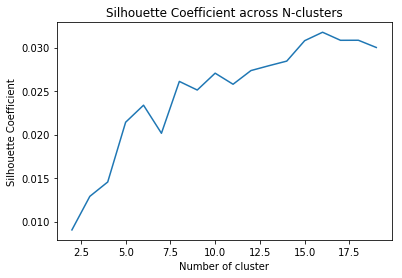

In [21]:
coef = {}
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=1, verbose=0, random_state=342).fit(tfidf_matrix)
    label = kmeans.labels_
    sil_coeff = silhouette_score(tfidf_matrix, label, metric='euclidean')
    # print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    coef[k] = sil_coeff

plt.figure
plt.plot(list(coef.keys()), list(coef.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.title('Silhouette Coefficient across N-clusters')
plt.show()

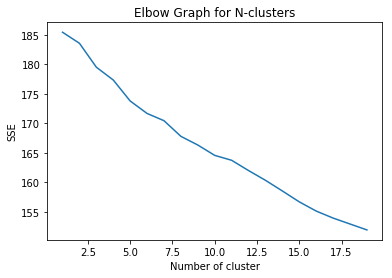

In [22]:
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=1, verbose=0, random_state=342).fit(tfidf_matrix)
    data["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title('Elbow Graph for N-clusters')
plt.show()

In [11]:
km = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=1, verbose=0, random_state=342)
km.fit(tfidf_matrix)
labels = km.labels_
clusters = labels.tolist()

In [12]:
distance = 1 - cosine_similarity(tfidf_matrix)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(distance)
xs, ys = pos[:, 0], pos[:, 1]

Text(0.5,1,'MDS output of News Headlines')

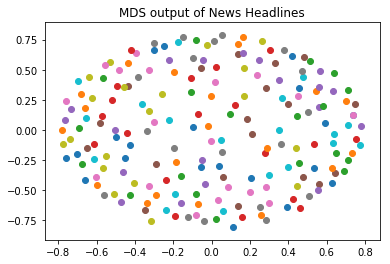

In [13]:
for x, y, in zip(xs, ys):
    plt.scatter(x, y)
plt.title('MDS output of News Headlines')

In [14]:
df_knn = pd.DataFrame(dict(label=clusters, data=data['Text'], x=xs, y=ys))

In [31]:
label_color_map = {0: 'tomato',
                   1: 'skyblue',
                   2: 'lightgrey',
                   3: 'pink',
                   4: 'plum',
                   5: 'yellow'}

Text(0.5,1,'News Headlines using KMeans Clustering')

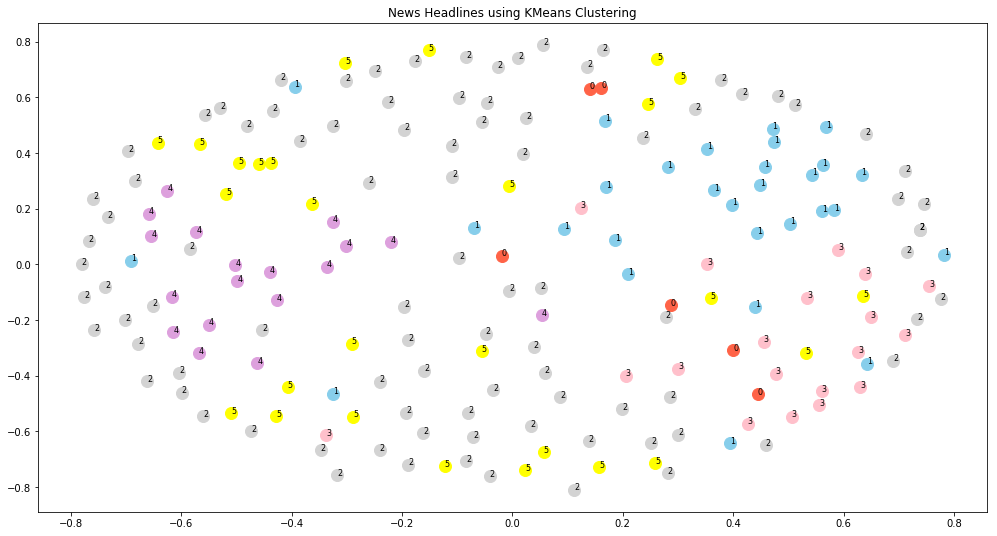

In [32]:
fig, ax = plt.subplots(figsize=(17, 9))
for index, row in df_knn.iterrows():
    cluster = row['label']
    label_color = label_color_map[row['label']]
    label_text = row['data']
    ax.plot(row['x'], row['y'], marker='o', ms=12, c=label_color)
    row = str(cluster) + ',' + label_text + '\n'

# ax.legend(numpoints=1)
for i in range(len(df_knn)):
    ax.text(df_knn.ix[i]['x'], df_knn.ix[i]['y'], df_knn.ix[i]['label'], size=8)

plt.title('News Headlines using KMeans Clustering')

In [19]:
df0 = df_knn[df_knn['label']==0]
df0

,data,label,x,y
11,"The best Data Science courses on the internet,...",0,-0.019490,0.030702
19,The 50 best free online university courses acc...,0,0.399736,-0.309731
45,The best free online courses of 2017 according...,0,0.139823,0.631551
84,The 50 best free online university courses acc...,0,0.160921,0.635257
131,Learn to visualize data with this free D3.js c...,0,0.286973,-0.148071
158,An overview of every Data Visualization course...,0,0.444512,-0.466273


In [48]:
df_knn.groupby(['label'])['data'].agg({'kmean':'size'})

C:\Users\fengy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,kmean
label,
0,6
1,29
2,93
3,19
4,18
5,27


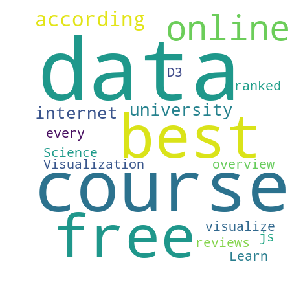

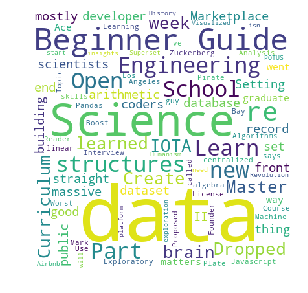

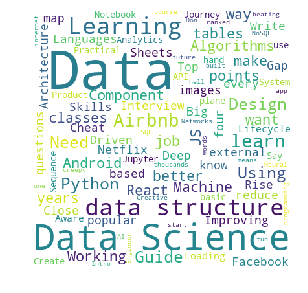

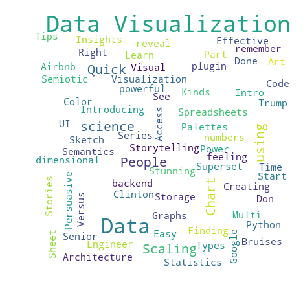

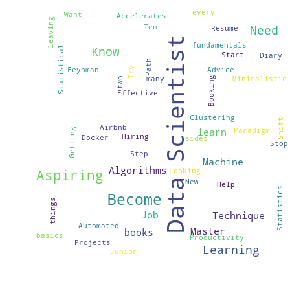

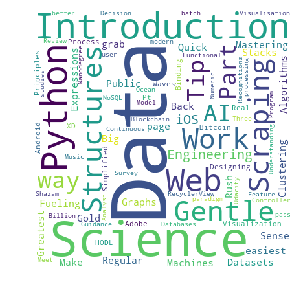

In [52]:
for i in range(6):
    df_new = df_knn[df_knn['label']==i]
    lines = df_new.data.str.cat(sep= ' ')
    stopwords = set(STOPWORDS)
    wordcloud0 = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(lines)
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud0) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)

plt.show()

### Hierarchical Clustering

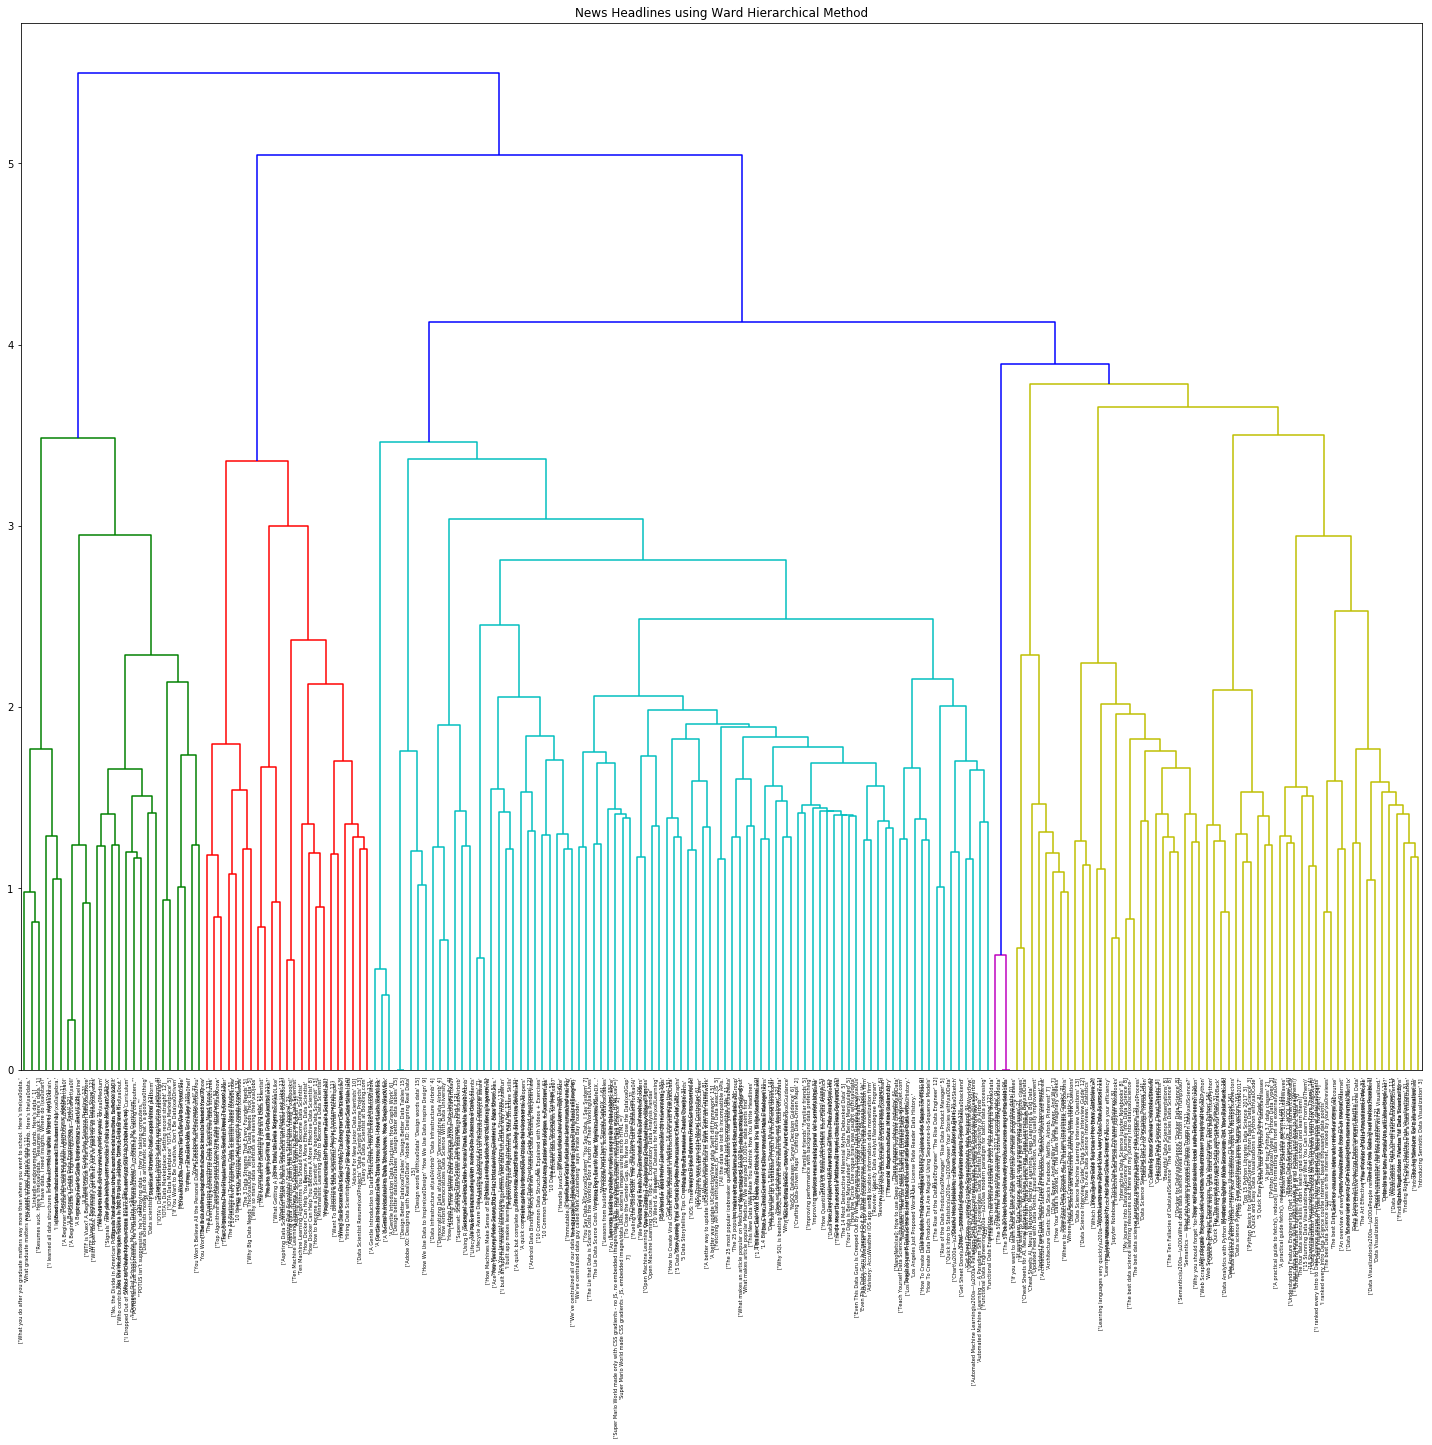

In [37]:
linkage_matrix = ward(distance)
fig, ax = plt.subplots(figsize=(20, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="top", labels=data.values, show_leaf_counts=True)
plt.tight_layout()
plt.title('News Headlines using Ward Hierarchical Method')
plt.show()

In [45]:
label = fcluster(linkage_matrix, 5, 'maxclust')

In [46]:
df_hei = pd.DataFrame({'team':data['Text'] , 'label':label})
df_hei.head()

,label,team
0,3,Design better data tables
1,1,Your Facebook data is creepy as hell
2,5,"Cheat Sheets for AI, Neural Networks, Machine ..."
3,2,Why so many data scientists are leaving their ...
4,3,"Why SQL is beating NoSQL, and what this means ..."


In [49]:
df_hei.groupby(['label'])['label'].agg({'hierarchical':'size'})

C:\Users\fengy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,hierarchical
label,
1,25
2,23
3,85
4,3
5,56


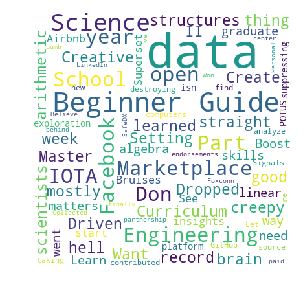

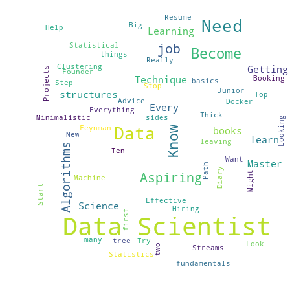

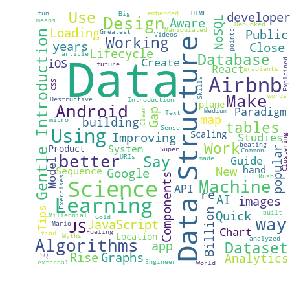

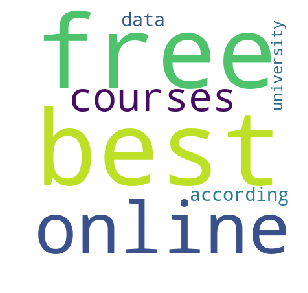

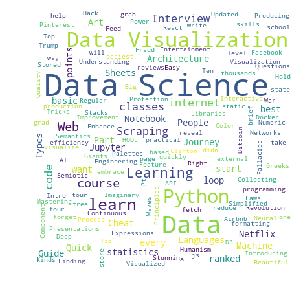

In [53]:
for i in range(1,6):
    df_new = df_hei[df_hei['label']==i]
    lines = df_new.team.str.cat(sep= ' ')
    stopwords = set(STOPWORDS)
    wordcloud0 = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(lines)
    plt.figure(figsize = (4, 4), facecolor = None) 
    plt.imshow(wordcloud0) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)

plt.show()